## Electrocardiography (ECG)

Materials are based on [Jupyter Notebooks](https://biosignalsplux.com/learn/notebooks.html) by biosignalsplux (see the [LICENSE](https://github.com/biosignalsplux/biosignalsnotebooks/blob/master/LICENSE)).

### Required packages

We will use special package created by biosignalsplux - as it is non-standard, we need to install it now:

In [ ]:
# install biosignalsplux package
!pip install biosignalsnotebooks

# install also system libraries necessary for libmagic
!apt-get install libmagic-dev

# install also BioSPPy (we will use them at the end of the lab)
!pip install biosppy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmagic-dev is already the newest version (1:5.32-2ubuntu0.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# necessary imports (as before)
import numpy as np
import pandas as pd
from scipy import signal

# import also the biosignalsplux library instaled in previous cell
import biosignalsnotebooks as bsnb

# for fancy plots
import bokeh
bokeh.io.output_notebook()

### Let's load some ECG data!

The notebook uses the sample ECG signals provided by biosignalsplux. But it may be more interesting to load your own signal recorded during the class!

In [ ]:
# load sample data
data, header = bsnb.load_signal("ecg_sample", get_header=True)

# load your own signal
# data, header = bsnb.load("my_signal.txt", get_header=True)

In [ ]:
# print the data
print(f"Header:\n{str(header)}\nData:\n{str(data)}")

Header:
{'channels': array([1], dtype=int32), 'comments': '', 'date': '2017-1-17', 'device': 'biosignalsplux', 'device connection': 'BTH00:07:80:3B:46:61', 'device name': '00:07:80:3B:46:61', 'digital IO': array([0, 1], dtype=int32), 'firmware version': 772, 'resolution': array([16], dtype=int32), 'sampling rate': 200, 'sync interval': 2, 'time': '14:50:32.316', 'sensor': ['ECG'], 'column labels': {1: 'channel_1'}}
Data:
{'CH1': array([32452, 32394, 32448, ..., 33120, 33164, 33192], dtype=uint16)}


You can see that there is only one channel (`'CH1'`) and it contains ECG data (`'sensor': [b'ECG']`).

Let's plot it somehow. As you probably noticed, there is no time vector - we need to create it by hand, using provided `header['sampling rate']`.  
We will create a vector starting from 0. If you want to generate real acquisition time vector, you can use `header['date']` and `header['time']` as a starting point.

In [ ]:
raw_ecg = data["CH1"]
sr = header["sampling rate"]
ecg_len = raw_ecg.shape[0]
time = np.linspace(start=0, stop=ecg_len/sr, num=ecg_len)

**Task 1**: plot the signal in time. Do not forget to label the axes!

In [ ]:
bf = bokeh.plotting.figure(
    x_axis_label= 'Time',
    y_axis_label= 'ECG',
    plot_width=   900,
    plot_height=  250 )
bf.line(time, raw_ecg)  
bokeh.plotting.show(bf)

Compare the sample data (above) with the plot below. Do you see any problems with our sample data?

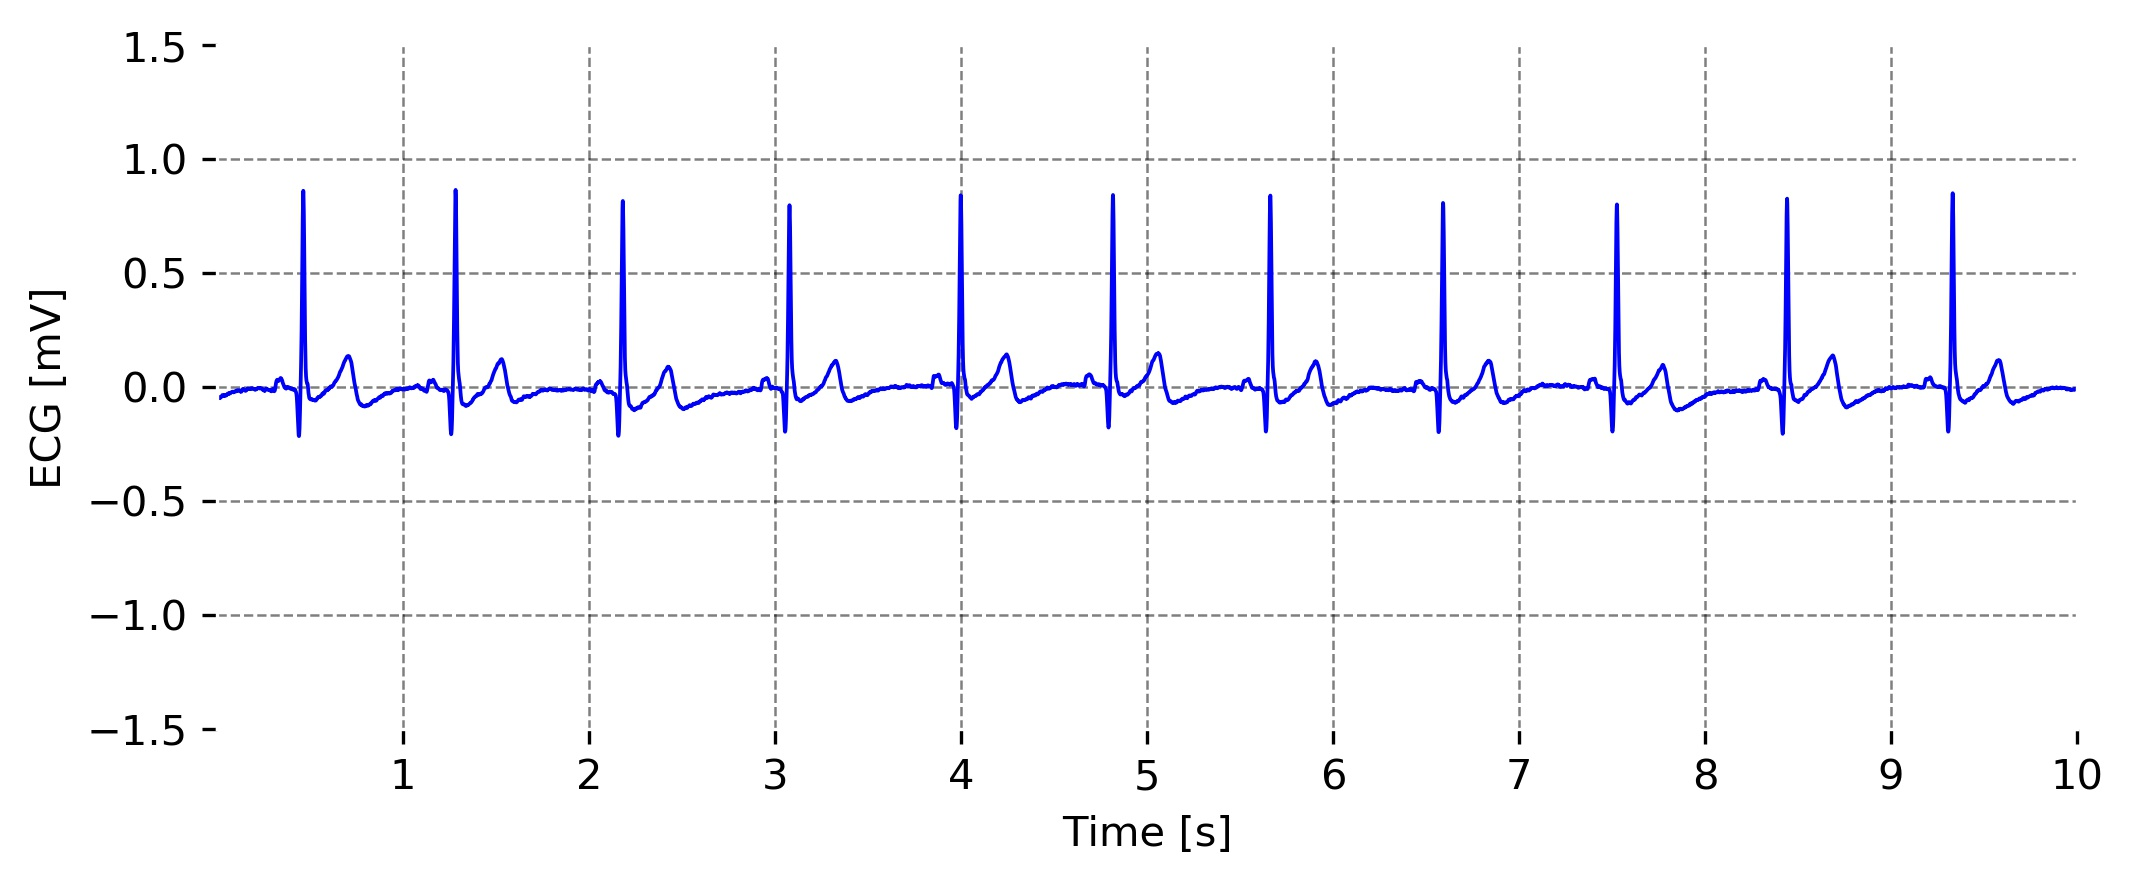

Yes, our signal **doesn't have proper units**.

It is a property of a variety of measuring devices, including biosignalsplux. They collect data in "their own units", which then need to be converted accordingly. The relevant functions can be found in the documentation.

### Unit conversion

**Task 2**: do the right conversion of sample ECG signal:

1. Read the documentation (see [docs (for sample ECG signal)](https://krzysztof.kutt.pl/didactics/psaw/ECG_Datasheet_for_Sample.pdf) or [docs (for signals recorded in class](https://krzysztof.kutt.pl/didactics/psaw/ECG_Datasheet.pdf)). On the second page, there is a transfer function that converts raw signal from analog-to-digital converter (`ADC`) to real ECG in *mV*.
2. Prepare the proper function for conversion (`convert_to_ecg(raw_signal)`) that returns the signal in *mV*.
3. Apply the function to the sample signal and plot the results (using `matplotlib` or `bokeh`)
4. Compare the new plot with the previous one. What is the difference? What changes to the signal were introduced during conversion?

In [ ]:
def convert_to_ecg(raw_signal):
  # n is already filled by proper value (from the signal header)
  n = header["resolution"][0]
  vcc =  3 
  g_ecg =  1000

  # do the conversion
  return  ((((raw_signal/2**n)-0.5)*vcc)/g_ecg)*1000

In [ ]:
# apply the function
converted_ecg = convert_to_ecg(raw_ecg)

# and plot the result (remember that time vector is in 'time' variable)
bf = bokeh.plotting.figure(
    x_axis_label= 'Time[s]',
    y_axis_label= 'ECG[mV]',
    plot_width=   900,
    plot_height=  250 )
bf.line(time, converted_ecg)  
bokeh.plotting.show(bf)


**Response (for Task 2, point 4):** `#_FILL_IN_YOUR_RESPONSE_HERE`
Zmieniła się skala i jednostka na wykresie.


### Pan–Tompkins algorithm

ECG signal is very specific - it consists of a series of periodically repeating QRS complexes. Their proper detection is the basis of ECG signal analysis. Two key parameters can be then calculated from it: **HR** (Heart Rate) and **HRV** (Heart Rate Variability).

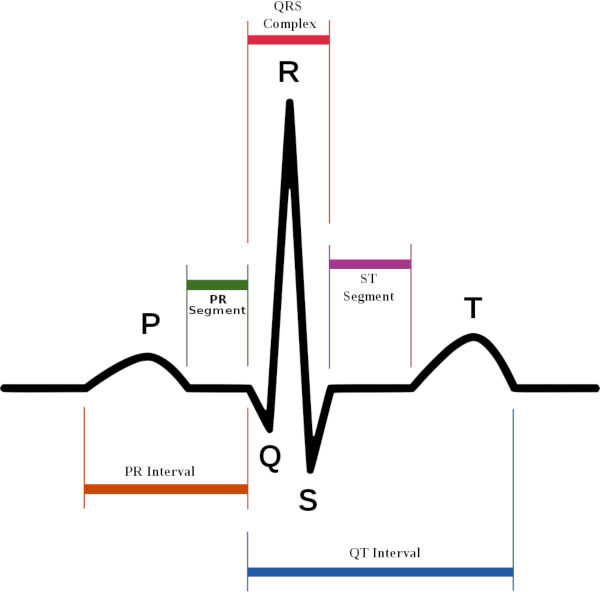

The commonly used algorithm for QRS complexes detection is Pan–Tompkins. Now, we will apply it to our sample signal!

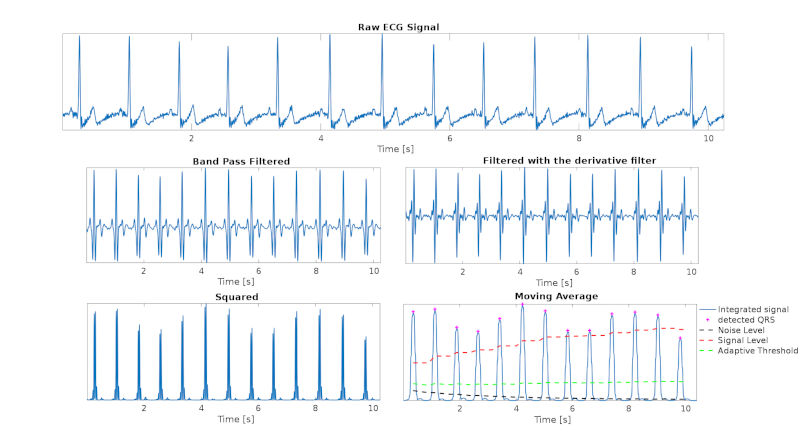

You can see an example of signal analysis using the Pan-Tompkins algorithm above (for larger image, see original [the one at Wikipedia](https://en.wikipedia.org/wiki/Pan%E2%80%93Tompkins_algorithm)). Now, we will apply all these processing steps to our signal!

In [ ]:
# This is a sumplementary function for Pan-Tompkins plots
def plot_pantompkins(series1, name1, series2, name2, peaks=False):
  colors = bokeh.palettes.brewer['Paired'][3]
  bf = bokeh.plotting.figure(x_axis_label='Time (s)', y_axis_label='ECG (mV)', plot_width=800, plot_height=250)
  bf.line(time, series1, alpha=0.8, line_width=2, color=colors[0], legend_label=name1)
  if peaks:
    bf.circle(time, series2, alpha=0.8, size=10, color=colors[1], legend_label=name2)
  else:
    bf.line(time, series2, alpha=0.8, line_width=2, color=colors[1], legend_label=name2)
  bf.legend.click_policy="hide"
  bokeh.plotting.show(bf)

**Task 3**: apply all the steps from Pan-Tompkins algorithm - see the cells below for details (and [the description of algorithm at Wikipedia](https://en.wikipedia.org/wiki/Pan%E2%80%93Tompkins_algorithm)).

In [ ]:
# Step 1: Band-pass filtering (5-15Hz) to remove noise

# Tip: Do you remember filtering lab? If not, it's time to review the code created there!
# Tip: sampling rate is in 'sr' variable (it was called 'fs' in previous lab)
cutoff = (5, 15) #Hz

filt_order = int(3*sr/cutoff[0])
filt_coefs = signal.firwin(filt_order, cutoff, fs=sr, pass_zero='bandpass')

filtered_ecg = np.convolve(converted_ecg,filt_coefs, mode='same')

# We will plot each step to see what we have done
# You can click on the legend to on/off the specific signal
plot_pantompkins(converted_ecg, "ECG signal", filtered_ecg, "Filtered ECG")

In [ ]:
# Step 2: Derivative filter to get information about slopes of QRS

# Tip: there is no need to use the formula provided at Wikipedia.
#      You can use numpy.ediff1d() function to calculate simple derivative

# _FILL_IN_YOUR_CODE_HERE
differentiated_ecg = np.ediff1d(filtered_ecg)

# plot for current step
plot_pantompkins(filtered_ecg, "Filtered ECG", differentiated_ecg, "Differentiated ECG")

In [ ]:
# Step 3: Squaring to enhance the dominant peaks (and to clear all the rest)

# _FILL_IN_YOUR_CODE_HERE
squared_ecg = differentiated_ecg** 2

# plot for current step
plot_pantompkins(differentiated_ecg, "Differentiated ECG", squared_ecg, "Squared ECG")

In [ ]:
# Step 4: Moving window integration

# Tip: to do this step you can simply convolve squared signal with proper moving window
# Tip: it is simple rectangle window; you can create it by: np.ones(window_size)
# Tip: you have to calculate the window_size (accordingly to Wikipedia description,
#      "The number of samples to average is chosen in order to average on windows of 150 ms")

# _FILL_IN_YOUR_CODE_HERE
window_size = 30
filter_window = np.ones(window_size)/window_size
integrated_ecg = np.convolve(squared_ecg, filter_window, mode = 'same')

# plot for current step
plot_pantompkins(squared_ecg, "Squared ECG", integrated_ecg, "Integrated ECG")

In [ ]:
# Step 5: Final peak detection

# Tip: The real algorithm is more complicated - here, we want to simply go through the whole signal
#      and do two checks for each sample:
#      1) in integrated_ecg check whether two neighbours have lower values than the central sample
#      2) for corresponding sample in converted_ecg, check whether it is above the threshold
#      If both are true, we have found a peak! (and we adjust the peaks_found[] accordingly)

# empty peaks_found array
peaks_found = np.empty(len(converted_ecg))
peaks_found[:] = np.nan

# a threshold; of course, you can experiment with this value
threshold = 0.135

for x in range(1, len(integrated_ecg)-1):
  if(integrated_ecg[x]>integrated_ecg[x-1] and integrated_ecg[x]>integrated_ecg[x+1] and converted_ecg[x]>threshold):
    peaks_found[x] = converted_ecg[x]

In [ ]:
plot_pantompkins(converted_ecg, "ECG signal", peaks_found, "Peaks found", peaks=True)

### Tachogram

The determination of peaks is just the beginning.
Then, for each adjacent pair of R peaks, we can calculate the distance in time between them. Such a plot is called **tachogram**.

It is an interesting plot, on which we can do further analysis (known as **HRV analysis**).


**Task 4**: prepare tachogram for sample ECG signal

* I have created `peak_times` array for you - there are times (in seconds) of all peaks you have found with Pan-Tompkins algorithm
* Your task is to calculate the time difference between given peak and the previous one - store the result in `tach_values`
* To plot them in time, prepare also the `tach_times` with the peak times (as we calculate the difference between peaks, `tach_times` will be shorter than `peak_times`

Example:  
For `peak_times = [0.7, 1.5, 2.4]`  
There should be:  
`tach_times = [1.5, 2.4]`  
`tach_values = [0.8, 0.9]`

In [ ]:
peak_times = np.array(time)[~np.isnan(peaks_found)]
print(peak_times)

[ 0.76032081  1.93081469  3.0212748   4.1067328   5.15217391  6.18761081
  7.16302237  8.14843816  9.13385395 10.11426762 11.08467708]


In [ ]:
tach_values = []
tach_times = []
for x in range(1, len(peak_times)):
    tach_values.append(peak_times[x] - peak_times[x-1])
    tach_times.append(peak_times[x])

Let's plot the tachogram (y axis should be named `Cardiac Cycle (s)`):

In [ ]:
bf = bokeh.plotting.figure(x_axis_label='Time (s)',
                           y_axis_label='Cardiac Cycle (s)',
                           plot_width=800,
                           plot_height=250)
bf.line(tach_times, tach_values)
bokeh.plotting.show(bf)

Of course, there are library functions for finding peaks and calculating tachogram - let's use the one developed by the biosignalsplux team to verify our own plot:

In [ ]:
tach_values_bsnb, tach_times_bsnb = bsnb.tachogram(raw_ecg, sr, signal=True, out_seconds=True)
bf = bokeh.plotting.figure(x_axis_label='Time (s)',
                           y_axis_label='Cardiac Cycle (s)',
                           plot_width=800,
                           plot_height=250)
bf.line(tach_times, tach_values, legend_label='Your tachogram')
bf.line(tach_times_bsnb, tach_values_bsnb, legend_label='bsnb.tachogram', color='red')
bokeh.plotting.show(bf)

### Heart Rate

As there are only a few peaks in the sample, there is nothing special to analyze in the above plot. Let's load a longer ECG sample for HRV analysis!

In [ ]:
# load the ecg_5_min sample (5 minutes); procedure as with the first sample
data, header = bsnb.load_signal("ecg_5_min", get_header=True)
raw_ecg = data["CH1"]
sr = header["sampling rate"]
time = bsnb.generate_time(raw_ecg, sr)

# plot the data
bf = bokeh.plotting.figure(x_axis_label='Time (s)', y_axis_label='Raw Data', plot_width=800, plot_height=250)
bf.line(time, raw_ecg)
bokeh.plotting.show(bf)

Now, we will calculate the tachogram using the library function (you already know how to do it manually):

In [ ]:
# we do not need to convert values to perform HRV analysis; do you know why?
tach_values, tach_times = bsnb.tachogram(raw_ecg, sr, signal=True, out_seconds=True)

In [ ]:
# let's plot the tachogram
bf = bokeh.plotting.figure(x_axis_label='Time (s)', y_axis_label='Cardiac Cycle (s)', plot_width=800, plot_height=250)
bf.line(tach_times, tach_values)
bokeh.plotting.show(bf)

**Task 5**: Calculate the Heart Rate

* Heart rate (HR) is the number of heartbeats per minute (BPM), i.e., the number of R peaks per minute.
* As you already has the information about R-R intervals (time difference in seconds between two adjacent peaks calculated in tachogram), you can simply calculate the BPM for each peak - take the R-R interval assigned to a given peak and calculate the BPM assuming that the heartbeats would have the same intervals all the time
* Next, calculate the mean HR
* Finally, plot the HR and the mean HR using `matplotlib` or `bokeh`

In [ ]:
bpm_values =  # _FILL_IN_YOUR_CODE_HERE

SyntaxError: ignored

In [ ]:
mean_hr =  # _FILL_IN_YOUR_CODE_HERE

In [ ]:
# let's plot the BPM
bf = bokeh.plotting.figure(x_axis_label='Time (s)', y_axis_label='BPM', plot_width=800, plot_height=250)
bf.line(tach_times, bpm_values, legend_label="Heart Rate")
bf.line(tach_times, [mean_hr] * len(tach_times), legend_label="Mean HR")
bokeh.plotting.show(bf)

### Heart Rate Variability
There are many HRV features one can extract from tachogram. And there are also dedicated Python libraries for this task.

Let's see at the more popular library: [hrv-analysis](https://aura-healthcare.github.io/hrv-analysis/index.html)

It includes the following features (see [the docs](https://aura-healthcare.github.io/hrv-analysis/hrvanalysis.html#hrvanalysis.extract_features.get_time_domain_features) for details):

* *Time domain features*: Mean_NNI, SDNN, SDSD, NN50, pNN50, NN20, pNN20, RMSSD, Median_NN, Range_NN, CVSD, CV_NNI, Mean_HR, Max_HR, Min_HR, STD_HR
* *Geometrical domain features*: Triangular_index, TINN
* *Frequency domain features*: LF, HF, VLF, LH/HF ratio, LFnu, HFnu, Total_Power
* *Non Linear domain features*: CSI, CVI, Modified_CSI, SD1, SD2, SD1/SD2 ratio, SampEn

**Task 6**: Calculate selected HRV features!

In [ ]:
!pip install hrv-analysis
import hrvanalysis

In [ ]:
# _FILL_IN_YOUR_CODE_HERE

### BioSPPy

Of course, there are also more general libraries for signal processing.

One of the most interesting ones available in Python is [BioSPPy](https://pypi.org/project/biosppy/).

In [ ]:
# import biosppy ecg
from biosppy.signals import ecg

In [ ]:
output = ecg.ecg(signal=raw_ecg, sampling_rate=sr, show=True)